<a href="https://colab.research.google.com/github/VladelProg/-/blob/master/EDL_Lab_2_Quantization_fix_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Квантование


## Цели

В этой работе предлагается проквантовать классическую модель нейронной сети, чтобы уменьшить как размер модели, так и задержку.

Цели этого задания следующие:

- Разобрать базовую концепцию **квантования**
- Реализовать и применить **квантование k-средних**
- Реализовать и применить **обучение с учетом квантования** для квантования k-средних
- Реализовать и применить **линейное квантование**
- Реализовать и применить **целочисленный инференс** для линейного квантования
- Пронаблюдать улучшение производительности (например, ускорения) за счет квантования
- Понять различия и компромиссы между разными подходами к квантованию



## Содержание

Работа делится на 2 основных раздела: ***Квантование методом K-средних*** и ***Линейное квантование***.

Всего ***10*** заданий:
- Для *Квантования методом K-средних* есть ***3*** задания (вопрос 1-3).
- Для *Линейного квантования* есть ***6*** задания (вопрос 4-9).
- В последнем (10) вопросе предлагается сравнить квантование методом k-средних и линейное квантование.

# Сетап

Ставим необходимые пакеты, загрузим наборы данных и предварительно обученную модель. Здесь мы используем набор данных CIFAR10 и сеть VGG, по аналогии, как мы использовали в предыдущей работе.



In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('Installing fast-pytorch-kmeans...')
! pip install fast-pytorch-kmeans 1>/dev/null
print('All required packages have been successfully installed!')

In [ ]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys
    from urllib.request import urlretrieve
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))
    add("avgpool", nn.AvgPool2d(2))
    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # x = x.mean([2, 3])
    x = x.view(x.shape[0], -1)

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # отправляем данные на GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # инференс
    outputs = model(inputs)

    # преобразуем логиты в индексы классов
    outputs = outputs.argmax(dim=1)

    # считаем метрику
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Еще вспомогательные функции (флопс, размер модели и т. д.)

In [ ]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

In [ ]:
def get_model_size(model: nn.Module, data_width=32):
    """
    считаем размер мдели в битах
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB


Функции для проверки


In [ ]:
def test_k_means_quantize(
    test_tensor=torch.tensor([
        [-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]]),
    bitwidth=2):
    def plot_matrix(tensor, ax, title, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=-0.5, vmax=0.5, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    fig, axes = plt.subplots(1,2, figsize=(8, 12))
    ax_left, ax_right = axes.ravel()

    print(test_tensor)
    plot_matrix(test_tensor, ax_left, 'исходный тензор')

    num_unique_values_before_quantization = test_tensor.unique().numel()
    k_means_quantize(test_tensor, bitwidth=bitwidth)
    num_unique_values_after_quantization = test_tensor.unique().numel()
    print('* Тестируем k_means_quantize()')
    print(f'    целевая разрядность: {bitwidth} bits')
    print(f'        число уникальных значений перед k-means квантованием: {num_unique_values_before_quantization}')
    print(f'        число уникальных значений после k-means квантования: {num_unique_values_after_quantization}')
    assert num_unique_values_after_quantization == min((1 << bitwidth), num_unique_values_before_quantization)
    print('* Test passed.')

    plot_matrix(test_tensor, ax_right, f'{bitwidth}-bit k-means квантованный тензор', cmap='tab20c')
    fig.tight_layout()
    plt.show()

In [ ]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1/3, zero_point=-1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'исходный тензор', vmin=real_min, vmax=real_max)
    _quantized_test_tensor = linear_quantize(
        test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Тестируем linear_quantize()')
    print(f'    целевая разрядность: {bitwidth} bits')
    print(f'        коэфф. масштаб: {scale}')
    print(f'        нулевая точка: {zero_point}')
    assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit линейно квантованный тензор',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'восстановленный тензор',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()


In [ ]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)
    assert _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)
    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'исходный вес', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'оригинальный вход', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'оригинальный выход', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit линейно квантованный вес',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit линейно квантованный вход',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'квантованный выход из quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'восстановленный вес',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'восстановленный вход',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'восстановленный выход',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Тест quantized_fc()')
    print(f'    целевая разрядность: {bitwidth} bits')
    print(f'      размер батча: {batch_size}')
    print(f'      входные каналы: {in_channels}')
    print(f'      выходные каналы: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

Загрузим предварительно обученную модель

In [ ]:
checkpoint_url = "https://cloud.tpu.ru/index.php/s/SdEXQPKgH6aFJG8/download/vgg.cifar.pretrained.pth"

checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda : model.load_state_dict(checkpoint['state_dict'])

In [ ]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

# Оценим точность и размер модели FP32

In [ ]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

# K-Means квантование

Квантование сжимает сеть, сокращая количество бит на вес, необходимое для представления сети. Квантованная сеть может иметь более высокую скорость инференса с аппаратной поддержкой.

В этом разделе мы рассмотрим квантование K-средних для нейронных сетей, как в [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization
And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf).

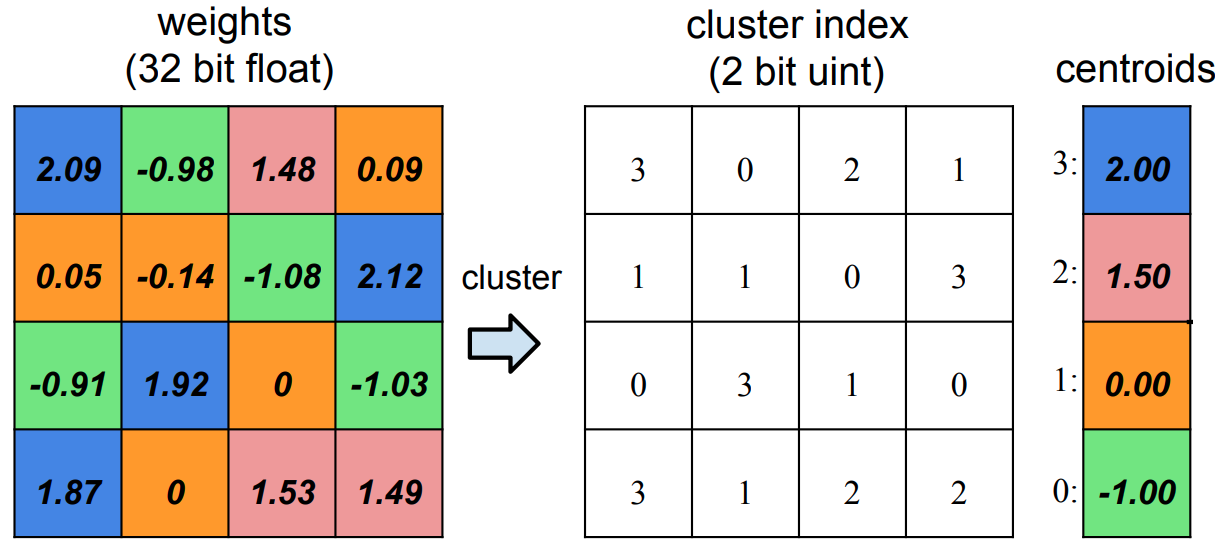

$n$-битное квантование при помощи k-средних разделит синапсы на $2^n$ кластеров, после чего синапсы в одном кластере будут иметь одинаковое значение веса.

Таким образом, квантование k-средних создаст кодовую книгу (***codebook***), включающую
* `centroids`: $2^n$ fp32 центров кластеров.
* `labels`: $n$-битный целочисленный тензор с теми же элементами исходного тензора весов fp32. Каждое целое число указывает, к какому кластеру оно принадлежит.

Во время инференса тензор fp32 генерируется на основе кодовой книги для инференса:

> ***quantized_weight* = *codebook.centroids*\[*codebook.labels*\].view_as(weight)**

In [ ]:
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

## Задание 1

Дополните следующую функцию квантования K-Means.

In [ ]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    квантование тензора используя кластеризацию методом к-средних
    :param fp32_tensor:
    :param bitwidth: [int] битовая разрадность квантования, default=4
    :param codebook: [Codebook] (центроиды кластера, лейблы в тензорном представлении)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] центры кластеров
            labels: [torch.(cuda.)LongTensor] лейблы в формате тензора
    """
    if codebook is None:
        ############### YOUR CODE STARTS HERE ###############
        # получить чисор кластеров на основе точности квантования

        n_clusters = 0
        ############### YOUR CODE ENDS HERE #################

        # использование к-средних для получения центроидов

        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    ############### YOUR CODE STARTS HERE ###############

    # декодирование кодбука в квантованный тензор к-средних для инференса

    quantized_tensor = 0

    ############### YOUR CODE ENDS HERE #################
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

Проверим функциональность квантования k-средних, применив доработанную выше функцию к фиктивному тензору.

In [ ]:
test_k_means_quantize()

## Задание 2

Последняя ячейка кода выполняет 2-битное квантование k-средних и выводит тензор до и после квантования. Каждый кластер отображается уникальным цветом. В квантованном тензоре отображается 4 уникальных цвета.

Вопрос: Если выполняется квантование k-средних по *n*-биту, сколько уникальных цветов будет отображено в квантованном тензоре?

**Your Answer:**

## Квантование методом K-средних на всей модели

Подобно тому, что мы делали в лабораторной работе 1, теперь мы обернули функцию квантования методом k-средних в класс для квантования всей модели. В классе `KMeansQuantizer` мы должны логировать "кодовые книги" (т. е. `centroids` и ​​`labels`), чтобы иметь возможность применять или обновлять кодовые книги всякий раз, когда меняются веса модели.

In [ ]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

Теперь давайте квантуем модель на 8 бит, 4 бита и 2 бита, используя квантование K-средних. *Обратите внимание, что мы игнорируем хранилище для кодовых книг при расчете размера модели.*

In [ ]:
print('Игнорируем хранилище для кодовых книг при расчете размера модели.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    recover_model()
    print(f'k-means квантованная модель into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means квантованная модель, размер={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means квантованная модель, точность={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

## Обученное квантование K-средних

Как мы видим из результатов последней ячейки, точность значительно падает при квантовании модели в более низкую разрадность. Соответственно, необходимо выполнить обучение с учетом квантования, чтобы восстановить точность.

Во время обучения с учетом квантования k-средних центроиды также обновляются, как приводится в работе в [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization
And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf).

Градиент для центроидов рассчитывается как,

> $\frac{\partial \mathcal{L} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \frac{\partial W_{j} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \mathbf{1}(I_{j}=k)$

где $\mathcal{L}$ — это потери, $C_k$ — это *k*-й центроид, $I_{j}$ — это метка для веса $W_{j}$. $\mathbf{1}()$ — это индикаторная функция, а $\mathbf{1}(I_{j}=k)$ означает $1\;\mathrm{if}\;I_{j}=k\;\mathrm{else}\;0$, *т.е.*, $I_{j}==k$.

В данной работе для упрощения, мы напрямую обновляем центроиды в соответствии с последними весами:

> $C_k = \frac{\sum_{j}W_{j}\mathbf{1}(I_{j}=k)}{\sum_{j}\mathbf{1}(I_{j}=k)}$

### Задание 3

Дополните следующую функцию обновления кодовой книги.

**Подсказка**:

Приведенное выше уравнение для обновления центроидов использует среднее/`mean` по весам в том же кластере в качестве обновленного значения центроида.

In [ ]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    обновление центроидов кодбука используя fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
    ############### YOUR CODE STARTS HERE ###############
        codebook.centroids[k] = 0
    ############### YOUR CODE ENDS HERE #################

Запустим следующую ячейку кода для тонкой настройки квантованной модели, чтобы восстановить точность. Мы остановим остановим процесс, если падение точности будет меньше 0.5.

In [ ]:
accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [8, 4, 2]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means квантовання модель into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means квантованная модель, размер ={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means квантованная модель, точность ={quantized_model_accuracy:.2f}% перед обучением с учетов квантования ")
    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Обучение с учетом квантования, снижение точности={accuracy_drop:.2f}% больше чем порог={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, dataloader['train'], criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, dataloader['test'])
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
    else:
        print(f"        Нет необходимости в обучении с учетом квантования, снижение точности ={accuracy_drop:.2f}% меньше порога={accuracy_drop_threshold:.2f}%")

# Линейное квантование

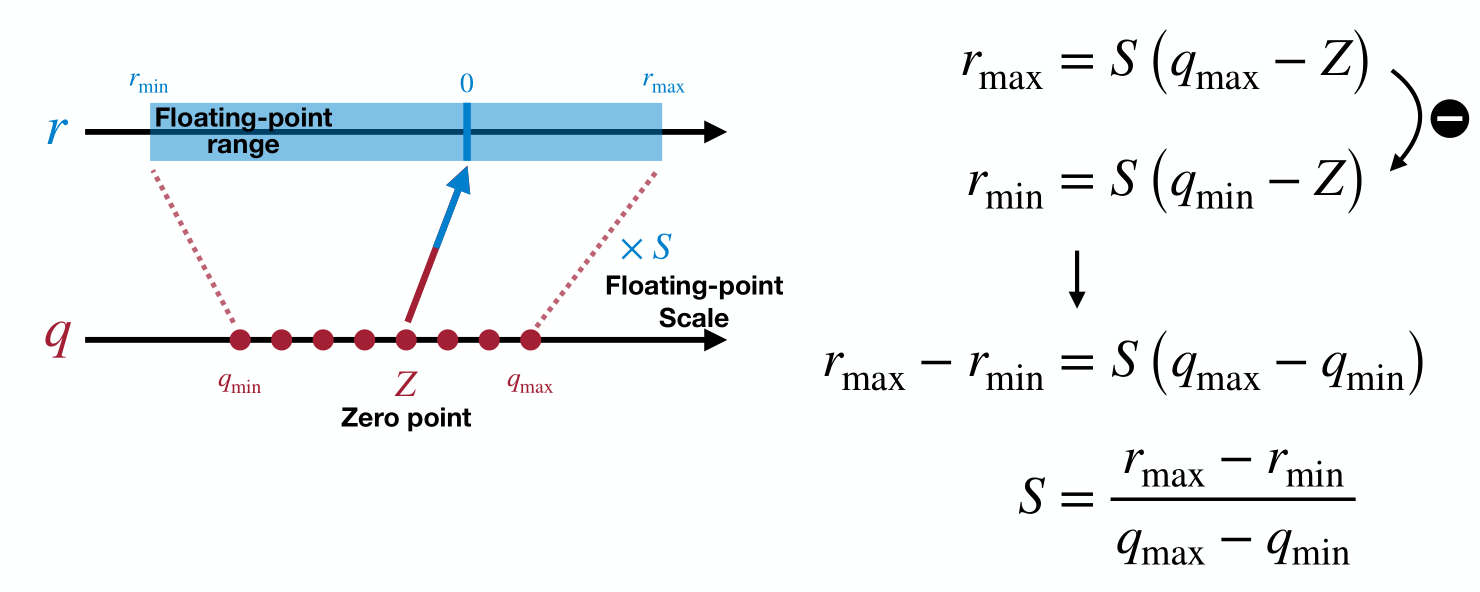

В этом разделе реализуем линейное квантование.

Линейное квантование напрямую округляет значение с плавающей точкой до ближайшего квантованного целого числа после усечения диапазона и масштабирования.

[Линейное квантование](https://arxiv.org/pdf/1712.05877.pdf) можно представить как

$r = S(q-Z)$

где $r$ — вещественное число с плавающей точкой, $q$ — *n*-битное целое число, $Z$ — *n*-битное целое число, а $S$ — вещественное число с плавающей точкой. $Z$ — нулевая точка квантования, а $S$ — масштабный коэффициент квантования. Обе константы — $Z$ и $S$ — являются параметрами квантования.

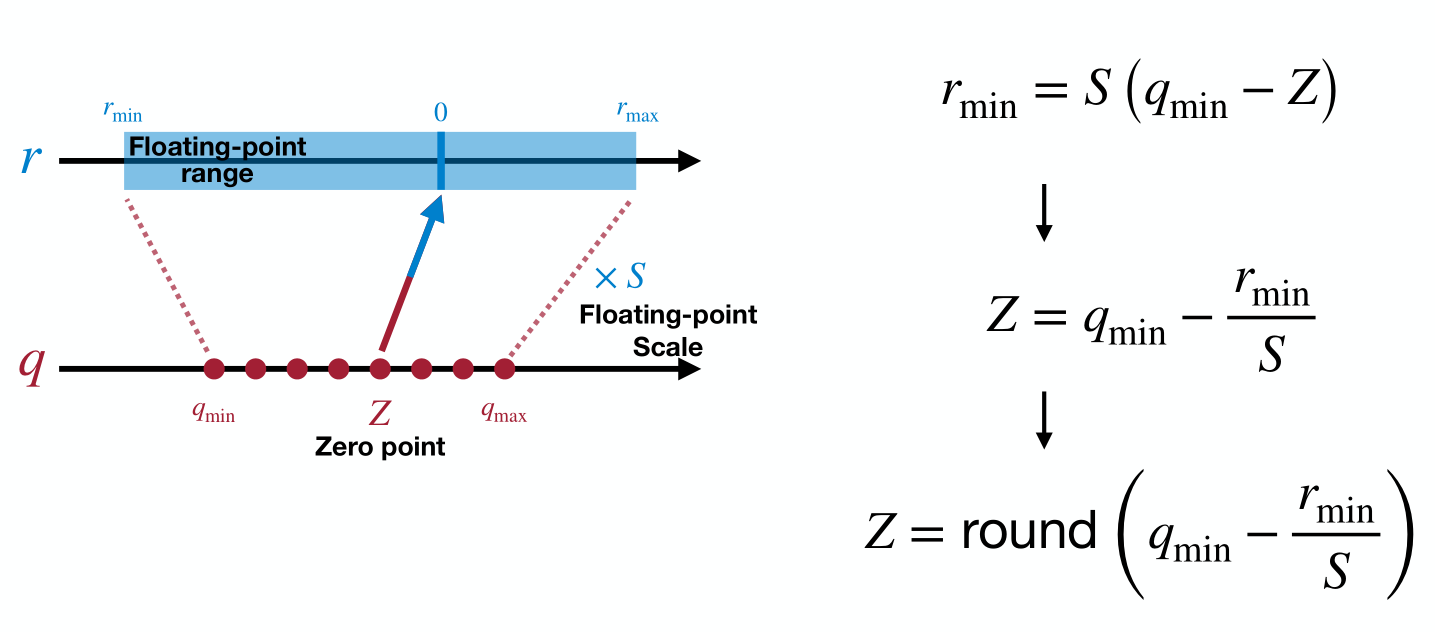

## *n*-битное целое число

*n*-битное целое число со знаком обычно представляется в [дополнительном коде](https://en.wikipedia.org/wiki/Two%27s_complement).

*n*-битное целое число со знаком может кодировать целые числа в диапазоне $[-2^{n-1}, 2^{n-1}-1]$. Например, 8-битное целое число попадает в диапазон [-128, 127].

In [ ]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

## Задание 4

дополните следующую функцию линейного квантования.

**Подсказка**:
* Из $r=S(q-Z)$ имеем $q = r/S + Z$.
* Оба $r$ и $S$ являются числами с плавающей точкой, и поэтому мы не можем напрямую прибавить целое число $Z$ к $r/S$. Следовательно, $q = \mathrm{int}(\mathrm{round}(r/S)) + Z$.
* Чтобы преобразовать [`torch.FloatTensor`](https://pytorch.org/docs/stable/tensors.html) в [`torch.IntTensor`](https://pytorch.org/docs/stable/tensors.html), можно использовать [`torch.round()`](https://pytorch.org/docs/stable/generated/torch.round.html#torch.round), [`torch.Tensor.round()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round.html#torch.Tensor.round), [`torch.Tensor.round_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round_) для первого преобразования всех значений в плавающее целое число, а затем использовать [`torch.Tensor.to(torch.int8)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to) для преобразования типа данных из [`torch.float`](https://pytorch.org/docs/stable/tensors.html) в [`torch.int8`](https://pytorch.org/docs/stable/tensors.html).


In [ ]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    линейное квантование для fp_tensor

        fp_tensor = (quantized_tensor - zero_point) * scale
      где,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] тензор с плавающей точной который необходимо квантовать
    :param bitwidth: [int] разрядность квантования
    :param scale: [torch.(cuda.)FloatTensor] коэфф. масштабирования
    :param zero_point: [torch.(cuda.)IntTensor] целевой центроид значений тензора
    :return:
        [torch.(cuda.)FloatTensor] квантованный тензор, значения которого - целые числа
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: масштабируем fp_tensor

    scaled_tensor = 0

    # Step 2: округляем значение до целочисленного

    rounded_tensor = 0

    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: смещаем rounded_tensor чтобы zero_point была 0

    shifted_tensor = 0

    ############### YOUR CODE ENDS HERE #################

    # Step 4: фиксируем shifted_tensor  чтобы он лежал в диапазоне битовой ширины
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

проверим функциональность определенного линейного квантования, применив указанную выше функцию к фиктивному тензору.

In [ ]:
test_linear_quantize()

## Задание 5

Теперь нам нужно определить коэффициент масштабирования $S$ и нулевую точку $Z$ для линейного квантования.

Напомним, что [линейное квантование](https://arxiv.org/pdf/1712.05877.pdf) можно представить как

$r = S(q-Z)$

### Масштаб

Линейное квантование проецирует диапазон с плавающей точкой [*fp_min*, *fp_max*] на квантованный диапазон [*quantized_min*, *quantized_max*]. То есть,

> $r_{\mathrm{max}} = S(q_{\mathrm{max}}-Z)$
>
> $r_{\mathrm{min}} = S(q_{\mathrm{min}}-Z)$

Вычитая эти два уравнения, получаем,

#### Задание 5.1

Выберите правильный ответ и удалите неправильные ответы в следующей текстовой ячейке.

> $S=r_{\mathrm{max}} / q_{\mathrm{max}}$

> $S=(r_{\mathrm{max}} + r_{\mathrm{min}}) / (q_{\mathrm{max}} + q_{\mathrm{min}})$

> $S=(r_{\mathrm{max}} - r_{\mathrm{min}}) / (q_{\mathrm{max}} - q_{\mathrm{min}})$

> $S=r_{\mathrm{max}} / q_{\mathrm{max}} - r_{\mathrm{min}} / q_{\mathrm{min}}$

Существуют различные подходы к определению $r_{\mathrm{min}}$ и $r_{\mathrm{max}}$ тензора с плавающей точкой `fp_tensor`.

* Наиболее распространенный метод — непосредственное использование минимального и максимального значения `fp_tensor`.
* Альтернативный метод — минимизация расстояния Кульбака-Лейблера для определения *fp_max*.


### Нулевая точка

После того, как мы определим коэффициент масштабирования $S$, мы можем напрямую использовать соотношение между $r_{\mathrm{min}}$ и $q_{\mathrm{min}}$ для вычисления нулевой точки $Z$.

#### Задание 5.2

Выберите правильный ответ и удалите неправильные ответы в следующей текстовой ячейке.

> $Z = \mathrm{int}(\mathrm{round}(r_{\mathrm{min}} / S - q_{\mathrm{min}})$

> $Z = \mathrm{int}(\mathrm{round}(q_{\mathrm{min}} - r_{\mathrm{min}} / S))$

> $Z = q_{\mathrm{min}} - r_{\mathrm{min}} / S$

> $Z = r_{\mathrm{min}} / S - q_{\mathrm{min}}$

### Задание 5.3

Дополните следующую функцию для вычисления масштаба $S$ и нулевой точки $Z$ из тензора с плавающей точкой $r$.

In [ ]:
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    получаем шкалу квантования для одного тензора
    :param fp_tensor: [torch.(cuda.)Tensor] float тензор, подлежащий квантованию
    :param bitwidth: [int] битовая ширина квантования
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    ############### YOUR CODE STARTS HERE ###############

    scale =  0
    zero_point = 0

    ############### YOUR CODE ENDS HERE #################

    # закрепим нулевую точку, чтобы она попадала в диапазон [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # преобразуем из float в int с помощью round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

Теперь обернем `linear_quantize()` из задания 4 и `get_quantization_scale_and_zero_point()` из задания 5 в одну функцию.

In [ ]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    линейное квантование для тензора признаков
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature подлежащие квантованию
    :param bitwidth: [int] разрядность квантования
    :return:
        [torch.(cuda.)Tensor] квантованный тензор
        [float] scale tensor
        [int] нулевая точка zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

## Особый случай: линейное квантование по тензору веса

Посмотрим на распределение значений веса.

In [ ]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

recover_model()
plot_weight_distribution(model)

Как видно из гистограмм выше, распределение значений веса почти симметрично относительно 0 (за исключением классификатора в этом случае). Поэтому мы обычно делаем нулевую точку $Z=0$ при квантовании весов.

Из $r = S(q-Z)$ имеем

> $r_{\mathrm{max}} = S \cdot q_{\mathrm{max}}$

и затем

> $S = r_{\mathrm{max}} / q_{\mathrm{max}}$

Мы напрямую используем максимальную величину значений веса как $r_{\mathrm{max}}$.

In [ ]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    получаем шкалу квантования для одного тензора веса
    :param weight: [torch.(cuda.)Tensor] floating вес, подлежащий квантованию
    :param bitwidth: [integer] разряность квантования
    :return:
        [floating scalar] масштаб
    """
    # полагаем что значения весов симметричны
    # также устанавливаем zero_point в 0 для весов
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

### Линейное квантование по каналам

Напомним, что для 2D-свертки тензор веса представляет собой 4-мерный тензор в форме (num_output_channels, num_input_channels, kernel_height, kernel_width).

Экспериментально можно показать, что использование различных коэффициентов масштабирования $S$ и нулевых точек $Z$ для различных выходных каналов даст лучшие результаты. Поэтому  необходимо определить коэффициент $S$ и нулевую точку $Z$ для субтензора каждого выходного канала независимо.


In [ ]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    линейное квантование для тензора веса
    использование разных масштабов и нулевых точек для разных выходных каналов
    :param tensor: [torch.(cuda.)Tensor] вес, подлежащий квантованию
    :param bitwidth: [int] разряность квантования
    :return:
        [torch.(cuda.)Tensor] квантованный тензор
        [torch.(cuda.)Tensor] тензор коэфф. масштабирования
        [int] нулевая точка (всегда 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

### Быстрый взгляд на линейное квантование весов

Посмотрим на распределение весов и размер модели при применении линейного квантования весов с различной битовой разрядностью.

In [ ]:
@torch.no_grad()
def peek_linear_quantization():
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()

peek_linear_quantization()

## Инференс после квантования

После квантования также изменяется инференс сверточных и полносвязных слоев.
Вспомним, что $r = S(q-Z)$, и мы имеем

> $r_{\mathrm{input}} = S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}})$
>
> $r_{\mathrm{weight}} = S_{\mathrm{weight}}(q_{\mathrm{weight}}-Z_{\mathrm{weight}})$
>
> $r_{\mathrm{bias}} = S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

Поскольку $Z_{\mathrm{weight}}=0$, $r_{\mathrm{weight}} = S_{\mathrm{weight}}q_{\mathrm{weight}}$.

Свертку с плавающей точкой можно записать как:

> $r_{\mathrm{output}} = \mathrm{CONV}[r_{\mathrm{input}}, r_{\mathrm{weight}}] + r_{\mathrm{bias}}\\
\;\;\;\;\;\;\;\;= \mathrm{CONV}[S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}}), S_{\mathrm{weight}}q_{\mathrm{weight}}] + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})\\
\;\;\;\;\;\;\;\;= \mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}]\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}}) + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

Чтобы еще больше упростить вычисления, мы могли бы позволить

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

так что

> $r_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}})$
> $\;\;\;\;\;\;\;\;\;= (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}})$

Поскольку
> $r_{\mathrm{output}} = S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}})$

мы имеем
> $S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}}) = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}})$

и таким образом
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

Поскольку $Z_{\mathrm{input}}$, $q_{\mathrm{weight}}$, $q_{\mathrm{bias}}$ определены до инференса, пусть

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

мы имеем

> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

Аналогично, для полносвязного слоя имеем

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

где

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{вес}}]$

### Задание 6

Дополните следующую функцию для линейного квантования смещения(bias).

**Подсказка**:

Из приведенного выше знаем, что

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$



In [ ]:
def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    линейное квантование для тензора смещения
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] вес смещения, подлежащий квантованию
    :param weight_scale: [float or torch.FloatTensor] тензор весовой шкалы
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] квантованный тензор смещения
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    ############### YOUR CODE STARTS HERE ###############

    bias_scale = 0

    ############### YOUR CODE ENDS HERE #################

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

### Квантованный полносвязный слой

Для квантованного полносвязного слоя мы сначала предварительно вычисляем $Q_{\mathrm{bias}}$. Напомним, что $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$.

In [ ]:
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    сдвиг квантованного смещения для включения input_zero_point для nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] квантованный bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] квантованный вес (torch.int8)
    :param input_zero_point: [int] входная нулевая точка
    :return:
        [torch.IntTensor] смещенный тензор с bias
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point

#### Задание 7
Дополните следующую функцию квантованного полносвязного слоя вывода.

**Подсказка**:

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

In [ ]:
def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    квантованный полносвязный слой
    :param input: [torch.CharTensor] квантованный вход (torch.int8)
    :param weight: [torch.CharTensor] квантованный выход (torch.int8)
    :param bias: [torch.IntTensor] квантованный bias со сдвигом или None (torch.int32)
    :param feature_bitwidth: [int] разрядность квантования входа и выхода
    :param weight_bitwidth: [int] разрядность квантования веса
    :param input_zero_point: [int] нулевая точка для входа
    :param output_zero_point: [int] нулевая точка для выхода
    :param input_scale: [float] масштаб для входных признаков
    :param weight_scale: [torch.FloatTensor] масштаб для веса по каналам
    :param output_scale: [float] масштаб для выходных признаков
    :return:
        [torch.CharIntTensor] квантованные значения выходных признаков (torch.int8)
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: целочисленный полносвязный (8-bit умножение с 32-bit сложением)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # текущая версия pytorch пока не поддерживает целочисленное linear() на GPU
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())

    ############### YOUR CODE STARTS HERE ###############

    # Step 2: масштабируем output

    # подсказка: 1. коэффициенты масштабирования — это числа с плавающей точкой,
    # нам также нужно преобразовать output в число с плавающей точкой
    # подсказка: 2. форма тензора коэфф. масштаба весов — [oc, 1, 1, 1], а форма вывода — [batch_size, oc]

    output = 0

    # Step 3: сдвигаем выход по значению output_zero_point

    output = 0

    ############### YOUR CODE ENDS HERE #################

    # убедимся, что все значения находятся в диапазоне битовой ширины.
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

Проверим функциональность определенного квантованного полносвязного слоя.

In [ ]:
test_quantized_fc()

### Квантованная свертка

Для квантованного сверточного слоя мы сначала предварительно вычисляем $Q_{\mathrm{bias}}$. Напомним, что $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$.

In [ ]:
def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    сдвиг квантованного bias'a для включения input_zero_point для nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] квантованный bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] квантованный вес (torch.int8)
    :param input_zero_point: [int] нулевая точка для входных значений
    :return:
        [torch.IntTensor] квантованный тензор bias'ов со сдвигом
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point

#### Задание 8
Дополните следующую квантованную функцию свертки.

**Подсказка**:
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

In [ ]:
def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    квантованная 2d свертка
    :param input: [torch.CharTensor] квантованный вход (torch.int8)
    :param weight: [torch.CharTensor] квантованны вес (torch.int8)
    :param bias: [torch.IntTensor] квантованный bias co сдвигом или None (torch.int32)
    :param feature_bitwidth: [int] разрядность квантованя входа и выхода
    :param weight_bitwidth: [int] разрядность квантования весов
    :param input_zero_point: [int] нулевая точка для inputs
    :param output_zero_point: [int] нулевая точка для outputs
    :param input_scale: [float] коэфф. масштаб входных признаков
    :param weight_scale: [torch.FloatTensor] коэфф. масштаба весов по каналам
    :param output_scale: [float] коэфф. масштаб выходных признаков
    :return:
        [torch.(cuda.)CharTensor] квантованный тензор выходных признаков
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: считаем целочисленную 2d свертку (8-bit умножение с 32-bit сложением)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # текущая версия pytorch не поддерживает целочисленное conv2d() на GPU
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    ############### YOUR CODE STARTS HERE ###############

    # подсказка: этот блок кода должен быть очень похож на quantized_linear()

    # Step 2: масштабируем output
    # подсказка: 1. коэффициенты масштабирования — это числа с плавающей точкой,
    # нам также нужно преобразовать output в число с плавающей точкой
    # подсказка: 2. форма тензора коэфф. масштаба весов — [oc, 1, 1, 1], а форма вывода — [batch_size, oc, height, width]

    output = 0

    # Step 3: сдвигаем выход по значению output_zero_point

    output = 0

    ############### YOUR CODE ENDS HERE #################

    # убедимся, что все значения лежат в диапазоне битовой ширины
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

## Задание 9
Собираем все вместе и выполняем квантование `int8` после обучения для модели. Мы преобразуем сверточные и линейные слои в модели в квантованную версию один за другим.

1. Во-первых, мы объединим слой BatchNorm с его предыдущим свёрточным слоем, что является стандартной практикой перед квантованием. Объединение batchnorm уменьшает дополнительное умножение во время инференса.

Также проверим, что модель после объединения `model_fused` имеет ту же точность, что и исходная модель (слияние BN является эквивалентным преобразованием, которое не меняет функциональность сети).


In [ ]:
def fuse_conv_bn(conv, bn):
    # modified from https://mmcv.readthedocs.io/en/latest/_modules/mmcv/cnn/utils/fuse_conv_bn.html
    assert conv.bias is None

    factor = bn.weight.data / torch.sqrt(bn.running_var.data + bn.eps)
    conv.weight.data = conv.weight.data * factor.reshape(-1, 1, 1, 1)
    conv.bias = nn.Parameter(- bn.running_mean.data * factor + bn.bias.data)

    return conv

print('Before conv-bn fusion: backbone length', len(model.backbone))
# объединим batchnorm в сверточные слои
recover_model()
model_fused = copy.deepcopy(model)
fused_backbone = []
ptr = 0
while ptr < len(model_fused.backbone):
    if isinstance(model_fused.backbone[ptr], nn.Conv2d) and \
        isinstance(model_fused.backbone[ptr + 1], nn.BatchNorm2d):
        fused_backbone.append(fuse_conv_bn(
            model_fused.backbone[ptr], model_fused.backbone[ptr+ 1]))
        ptr += 2
    else:
        fused_backbone.append(model_fused.backbone[ptr])
        ptr += 1
model_fused.backbone = nn.Sequential(*fused_backbone)

print('After conv-bn fusion: backbone length', len(model_fused.backbone))
# проверка работоспособности, больше нет BN
for m in model_fused.modules():
    assert not isinstance(m, nn.BatchNorm2d)

# точность останется прежней после слияния
fused_acc = evaluate(model_fused, dataloader['test'])
print(f'Accuracy of the fused model={fused_acc:.2f}%')

2. Запустим модель с некоторыми образцами данных, чтобы получить диапазон каждой карты признаков, чтобы мы могли получить диапазон карт признаков и вычислить их соответствующие коэффициенты масштабирования и нулевые точки.


In [ ]:
# добавим логирование минимального и максимального значения активации
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model_fused)
sample_data = iter(dataloader['train']).__next__()[0]
model_fused(sample_data.cuda())

# remove hooks
for h in hooks:
    h.remove()


3. Наконец, сделаем квантование модели. Мы преобразуем модель в следующее отображение


```python
nn.Conv2d: QuantizedConv2d,
nn.Linear: QuantizedLinear,
# следующие два — просто обертка, так как текущие
# модули torch не поддерживают формат данных int8;
# временно преобразуем их в fp32 для вычислений
nn.MaxPool2d: QuantizedMaxPool2d,
nn.AvgPool2d: QuantizedAvgPool2d,
```

In [ ]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # текущая версия Pytorch не поддерживает IntTensor как nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # текущая версия Pytorch не поддерживает IntTensor как nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # текущая версия pytorch не поддерживает целочисленный MaxPool
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # текущая версия pytorch не поддерживает целочисленный AvgPool
        return super().forward(x.float()).to(torch.int8)

# используем int8 квантование
feature_bitwidth = weight_bitwidth = 8
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'

        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)

        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[relu_name], feature_bitwidth)

        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        shifted_quantized_bias = \
            shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                        input_zero_point)

        quantized_conv = QuantizedConv2d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# квантованный классификатор
fc_name = 'classifier'
fc = model.classifier
input_scale, input_zero_point = \
    get_quantization_scale_and_zero_point(
        input_activation[fc_name], feature_bitwidth)

output_scale, output_zero_point = \
    get_quantization_scale_and_zero_point(
        output_activation[fc_name], feature_bitwidth)

quantized_weight, weight_scale, weight_zero_point = \
    linear_quantize_weight_per_channel(fc.weight.data, weight_bitwidth)
quantized_bias, bias_scale, bias_zero_point = \
    linear_quantize_bias_per_output_channel(
        fc.bias.data, weight_scale, input_scale)
shifted_quantized_bias = \
    shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                input_zero_point)

quantized_model.classifier = QuantizedLinear(
    quantized_weight, shifted_quantized_bias,
    input_zero_point, output_zero_point,
    input_scale, weight_scale, output_scale,
    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
)

Процесс квантования завершен, визуализируем архитектуру, а также проверим точность квантованной модели.


### Задание 9.1

Чтобы запустить квантованную модель, нам нужна дополнительная предварительная обработка для преобразования входных данных из диапазона (0, 1) в диапазон `int8` (-128, 127). Дополните код ниже, чтобы завершить препроцессинг.

**Подсказка**: вы должны обнаружить, что квантованная модель имеет примерно такую ​​же точность, как и аналог `fp32`.


In [ ]:
print(quantized_model)

def extra_preprocess(x):
    # hint: вам необходимо преобразовать исходный ввод fp32 диапазона (0, 1)
    #  в формат int8 в диапазоне (-128, 127)
    ############### YOUR CODE STARTS HERE ###############

    return 0.clamp(-128, 127).to(torch.int8)

    ############### YOUR CODE ENDS HERE #################

int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                               extra_preprocess=[extra_preprocess])
print(f"int8 model has accuracy={int8_model_accuracy:.2f}%")


### Задание 9.2
Вопрос: Объясните, почему в линейно-квантованной модели нет слоя ReLU.

**Your Answer:**


## Задание 10

Вопрос: Сравните преимущества и недостатки квантования на основе k-средних и линейного квантования. Можно сразу начать с точки зрения точности, задержки, аппаратной поддержки и т. д.


**Your Answer:**

